In [ ]:
!pip install scalecast --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.0/890.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.1 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.8-py3-none-any.whl size=111902 sha256=d742191e8f0ba6bc4a984471fc30b9d76ba9e152fc672070f0a843bf9438649c
  Stored in directory: /root/.cache/pip/wheels/ee/c3/95/9ced84cd0a8b34198d5cc67567389d1906b13408e627b31ca2
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107729 sha256=0d32f4e50ba46d8e70151091e5bc5e9cb989cbd1d8dcb65c86794d965a098f65
  Stored in directory

In [ ]:
!pip install tensorflow

In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 12.8 MB/s eta 0:00:00


In [ ]:

from sklearn import preprocessing, svm
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools

from scalecast.Forecaster import Forecaster

from tensorflow.keras.callbacks import EarlyStopping

from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.auxmodels import auto_arima

from sklearn.preprocessing import MinMaxScaler

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sktime.utils.plotting import plot_series

import xgboost as xgb

## Functions

In [ ]:
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter
  :param ts: pandas Series
  :param window: num - for rolling stats
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''

def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):
   rolling_mean = ts.rolling(window=window).mean()
   rolling_std = ts.rolling(window=window).std()
   plt.figure(figsize=figsize)
   plt.plot(ts[window:], label='Actual values', color="black")
   if plot_ma:
      plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")
   if plot_intervals:
      lower_bound = rolling_mean - (1.96 * rolling_std)
      upper_bound = rolling_mean + (1.96 * rolling_std)
   plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
   plt.legend(loc='best')
   plt.grid(True)
   plt.show()

In [ ]:
'''
Find outliers using sklearn unsupervised support vetcor machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [ ]:
'''
Interpolate outliers in a ts.
'''
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

In [ ]:
'''
Test stationarity by:
    - running Augmented Dickey-Fuller test wiht 95%
    - plotting mean and variance of a sample from data
    - plottig autocorrelation and partial autocorrelation
'''
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=
                              (15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))

        ## plot ts with mean/std of a sample from the first x%
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean() + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean() - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red",
                            linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'],
                y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,
                legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index,
                           y1=dtf_ts['lower'].head(sample_size),
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')

        ## test stationarity (Augmented Dickey-Fuller)
    adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,autolag="AIC")
    adf, p, critical_value = adfuller_test[0], adfuller_test[1], adfuller_test[4]["5%"]
    p = round(p, 3)
    conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
    ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+
                        '(p value: '+str(p)+')')

        ## pacf (for AR) e acf (for MA)
    smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax, title="Partial Autocorrelation (for AR component)")
    smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,title="Autocorrelation (for MA component)")
    plt.tight_layout()

In [ ]:
def forecst(a, name):
    a = a[(a.DATE <= df_test.ds.max()) & (a.DATE >= df_test.ds.min())]
    mape_ph = mean_absolute_percentage_error(a['Actuals'], a['FittedVals'], symmetric=True)
    mse_ph = mean_squared_error(a['Actuals'], a['FittedVals'], squared=False)
    print(f"The Smape loss value for {name} model is {mape_ph:.6f}")
    print(f"The RMSE loss value for {name} model is {mse_ph:.6f}")

    plot_series(a['FittedVals'], a['Actuals'], labels=["y_pred","y_test"], title = f'{name} Test predict-actuals plot')
    plt.show();

    f = plt.figure(figsize=(10, 7))
    ax = sns.lineplot(x="DATE", y="Residuals", markers=True, data=a)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();

In [ ]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [ ]:
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

In [ ]:
#######################
### Model framework ###
#######################

def cap_floor(train_dset, test_dset, name, initial, period, horizon, units, growth = 'linear'):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0
    #return train_df, test_dset

    ### Baseline model ###

    m = Prophet(growth = growth)
    m.fit(train_dset)

    ### Strict model ###

    m_strict = Prophet(changepoint_prior_scale=0.01,
                       weekly_seasonality=True,
                       daily_seasonality=True,
                       yearly_seasonality=True,
                       seasonality_mode = 'additive',
                       growth = growth)
    m_strict.fit(train_dset)

    ### Flexible model ###

    m_flex = Prophet(changepoint_prior_scale=0.5, growth = growth)
    m_flex.fit(train_dset)

    ### Holiday model ###

    m_hol = Prophet(holidays=holidays, growth = growth)
    #m_hol.add_regressor('Is_month_end')
    #m_hol.add_regressor('Year')
    m_hol.add_regressor('Day')
    m_hol.add_regressor('Week')
    m_hol.add_regressor('Dayofweek')
    m_hol.add_regressor('Dayofyear')
    #m_hol.add_regressor('Is_month_start')
    #m_hol.add_regressor('Is_quarter_end')
    #m_hol.add_regressor('Is_quarter_start')
    #m_hol.add_regressor('Is_year_end')
    #m_hol.add_regressor('Is_year_start')
    m_hol.fit(train_dset)

    ### Regressors ###

    m_reg = Prophet(changepoint_prior_scale=0.01, growth = growth)
    #m_reg.add_regressor('Is_month_end')
    #m_reg.add_regressor('Year')
    #m_reg.add_regressor('Month')
    m_reg.add_regressor('Week')
    m_reg.add_regressor('Day')
    m_reg.add_regressor('Dayofweek')
    m_reg.add_regressor('Dayofyear')
    #m_reg.add_regressor('Is_month_start')
    #m_reg.add_regressor('Is_quarter_end')
    #m_reg.add_regressor('Is_quarter_start')
    #m_reg.add_regressor('Is_year_end')
    #m_reg.add_regressor('Is_year_start')
    m_reg.fit(train_dset)

    ### Holiday-Regressors-Seasonality ###

    m_hrs = Prophet(weekly_seasonality=True,
                    daily_seasonality=True,
                    yearly_seasonality=True,
                    seasonality_mode = 'additive',
                    changepoint_prior_scale = 0.1,
                    seasonality_prior_scale = 10.0,
                    holidays=holidays,
                    growth = growth)

    #m_hrs.add_regressor('Is_month_end')
    #m_hrs.add_regressor('Year')
    #m_hrs.add_regressor('Month')
    m_hrs.add_regressor('Day')
    m_hrs.add_regressor('Week')
    m_hrs.add_regressor('Dayofweek')
    m_hrs.add_regressor('Dayofyear')
    #m_hrs.add_regressor('Is_month_start')
    #m_hrs.add_regressor('Is_quarter_end')
    #m_hrs.add_regressor('Is_quarter_start')
    #m_hrs.add_regressor('Is_year_end')
    #m_hrs.add_regressor('Is_year_start')
    m_hrs.fit(train_dset)

    ### Holiday-Regressors-Seasonality ###

    m_comp = Prophet(growth = growth,
                    seasonality_mode = 'additive',      # seasonality_mode = 'multiplicative',
                    changepoint_prior_scale = 0.1,
                    seasonality_prior_scale = 10.0,
                    holidays_prior_scale = 20.0,
                    weekly_seasonality = True,
                    daily_seasonality = True,
                    yearly_seasonality = False,
                    holidays=holidays,
                    ).add_seasonality(
                        name = 'monthly',
                        period = 30.5,
                        fourier_order = 55
                    ).add_seasonality(
                        name = 'daily',
                        period = 1,
                        fourier_order = 3,
                        prior_scale = 30
                    ).add_seasonality(
                        name = 'weekly',
                        period = 7,
                        fourier_order = 10,
                        prior_scale = 40
                    )

    #m_comp.add_regressor('Is_month_end')
    #m_comp.add_regressor('Year')
    #m_comp.add_regressor('Month')
    m_comp.add_regressor('Day')
    m_comp.add_regressor('Week')
    m_comp.add_regressor('Dayofweek')
    m_comp.add_regressor('Dayofyear')
    #m_comp.add_regressor('Is_month_start')
    #m_comp.add_regressor('Is_quarter_end')
    #m_comp.add_regressor('Is_quarter_start')
    #m_comp.add_regressor('Is_year_end')
    #m_comp.add_regressor('Is_year_start')
    m_comp.fit(train_dset)

    df_all = pd.DataFrame()

    y_train = train_dset.y
    y_test = test_dset.y
    y_test.index = y_test.index + max(y_train.index)
    print(y_train.shape[0], y_test.shape[0])

    df_cv, df_p, forecast, prop_test = mod_diag(m, 'Baseline model', test_dset, y_train, y_test, name, initial, period, horizon, units)
    df_p['Model'] = 'Baseline'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_strict, 'Strict model', test_dset, y_train, y_test, name, initial, period, horizon, units)
    df_p['Model'] = 'Strict'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_flex, 'Flexible model', test_dset, y_train, y_test, name, initial, period, horizon, units)
    df_p['Model'] = 'Flexible'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_reg, 'Regressor model', test_dset, y_train, y_test, name, initial, period, horizon, units)
    df_p['Model'] = 'Regressor'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_hol, 'Holiday model', test_dset, y_train, y_test, name, initial, period, horizon, units)
    df_p['Model'] = 'Holiday'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_hrs, 'Holiday-Regressor-Seasonal model', test_dset, y_train, y_test, name, initial, period, horizon, units)
    df_p['Model'] = 'HRS'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_cv, df_p, forecast, prop_test = mod_diag(m_comp, 'Constructed model', test_dset, y_train, y_test, name, initial, period, horizon, units)
    df_p['Model'] = 'Constructed'
    df_all = pd.concat([df_all,df_p], axis = 0).reset_index(drop=True)
    print(df_all.shape)

    df_all['days'] = df_all['horizon'].astype('timedelta64[D]')
    df_all['days'] = df_all['days'].astype(int)

    f = plt.figure(figsize=(19, 15))
    ax = sns.lineplot(x="days", y="smape", hue="Model", markers=True, data=df_all)
    ax.set(xlabel='Date', ylabel='SMAPE')
    plt.show();

    return df_all

In [ ]:
def mod_diag(model, mod_name, test_df, y_train, y_test, name, initial, period, horizon, units):
    f = plt.figure(figsize=(19, 15))
    plot_series(y_train, y_test, labels=["y_train", "y_test"], title = f'{name} Train-test plot');

    df_cv, df_p, forecast, prop_test = cv_exam(model, test_df, y_test, initial, period, horizon, units)
    fig = model.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), model, forecast)
    mape_ph = mean_absolute_percentage_error(prop_test['y'], prop_test['yhat'], symmetric=True)
    mse_ph = mean_squared_error(prop_test['y'], prop_test['yhat'], squared=False)
    print(f"The Smape loss value for {name} and {mod_name} model is {mape_ph:.6f}")
    print(f"The RMSE loss value for {name} and {mod_name} model is {mse_ph:.6f}")

    plot_series(prop_test['yhat'], y_test, labels=["y_pred","y_test"], title = f'{name} {mod_name} Test predict-actuals plot')
    plt.show();

    fig = model.plot_components(forecast)
    f = plt.figure(figsize=(19, 15))
    ax = sns.lineplot(x="ds", y="residual", markers=True, data=df_cv)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show();
    return df_cv, df_p, forecast, prop_test

def cv_exam(model, test_df, y_test, initial, period, horizon, units):

    forecast = model.predict(test_df)
    df_cv = cross_validation(model, initial = initial, period = period, horizon = horizon)
    df_p = performance_metrics(df_cv)
    df_cv['residual'] = df_cv['y'] - df_cv['yhat']
    prop_test = pd.merge(test_df,forecast[['yhat','ds']],on=['ds'],how='inner')
    prop_test.index = y_test.index

    return df_cv, df_p, forecast, prop_test

In [ ]:
def all_mod(train_dset, test_dset, params, df_comp, initial, period, horizon, name):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0

    y_train = train_dset.y
    y_test = test_dset.y
    y_test.index = y_test.index + max(y_train.index)
    print(y_train.shape[0], y_test.shape[0])

    auto_model = Prophet(changepoint_prior_scale = params['changepoint_prior_scale'],
                         seasonality_prior_scale = params['seasonality_prior_scale'],
                         seasonality_mode = params['seasonality_mode'],
                         growth = params['growth'],
                         holidays = holidays)

    #auto_model.add_regressor('Is_month_end')
    #auto_model.add_regressor('Year')
    #auto_model.add_regressor('Month')
    auto_model.add_regressor('Day')
    auto_model.add_regressor('Week')
    auto_model.add_regressor('Dayofweek')
    auto_model.add_regressor('Dayofyear')
    #auto_model.add_regressor('Is_month_start')
    #auto_model.add_regressor('Is_quarter_end')
    #auto_model.add_regressor('Is_quarter_start')

    ### Fit the model on the training dataset ###

    auto_model.fit(train_dset)

    ### Cross validation ###
    auto_model_cv, auto_model_p, forecast_auto, prop_test_auto = cv_exam(auto_model, test_dset, y_test, initial, period, horizon)

    fig = auto_model.plot(forecast_auto)
    a = add_changepoints_to_plot(fig.gca(), auto_model, forecast_auto)

    mape_ph_auto = mean_absolute_percentage_error(prop_test_auto['y'], prop_test_auto['yhat'], symmetric=True)

    print(f"The Smape loss value for {name} is {mape_ph_auto:.6f}")
    # 0.111345
    print(f"The RMSE value is {mean_squared_error(prop_test_auto['y'], prop_test_auto['yhat'], squared=False)}")
    # 1186.9104787999713
    plot_series(prop_test_auto['yhat'], y_test, labels=["y_pred", "y_test"], title = f'{name} Hyperparameter Train-test plot');

    f = plt.figure(figsize=(19, 15))
    ax = sns.lineplot(x="ds", y="residual", markers=True, data=auto_model_cv)
    ax.set(xlabel='Dates', ylabel='Residuals')
    plt.show()

    ### Model performance metrics ###
    auto_model_pm = performance_metrics(auto_model_cv, rolling_window=1)
    print(auto_model_pm)

    auto_model_p['Model'] = 'Hyperparameter'

    df_comp = pd.concat([df_comp,auto_model_p], axis = 0).reset_index(drop=True)
    df_comp['days'] = df_comp['horizon'].astype('timedelta64[D]')
    df_comp['days'] = df_comp['days'].astype(int)

    f = plt.figure(figsize=(19, 15))
    ax = sns.lineplot(x="days", y="smape", hue="Model", markers=True, data=df_comp)
    ax.set(xlabel='Date', ylabel='SMAPE')
    plt.show();
    return df_comp


In [ ]:
def hyper(train_dset, test_dset, initial, period, horizon, units):

    train_dset['cap'] = max(int(max(train_dset.y) * 1.1),int(max(test_dset.y) * 1.1))
    train_dset['floor'] = 0
    test_dset['cap'] = train_dset['cap']
    test_dset['floor'] = 0

    ### Create a list to store MAPE values for each combination ###
    mapes = []

    ### Use cross validation to evaluate all parameters ###

    for params in all_params:
        ### Fit a model using one parameter combination ###
        m = Prophet(**params)

        #m.add_regressor('Is_month_end')
        #m.add_regressor('Year')
        #m.add_regressor('Month')
        m.add_regressor('Day')
        m.add_regressor('Week')
        m.add_regressor('Dayofweek')
        m.add_regressor('Dayofyear')
        #m.add_regressor('Is_month_start')
        #m.add_regressor('Is_quarter_end')
        #m.add_regressor('Is_quarter_start')
        m.fit(train_dset)

        ### Cross-validation ###
        df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon, parallel="processes")

        ### Model performance ###
        df_p = performance_metrics(df_cv, rolling_window=1)

        ### Save model performance metrics ###
        mapes.append(df_p['smape'].values[0])

    ### Tuning results
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes
    # Find the best parameters
    best_params = all_params[np.argmin(mapes)]
    print(best_params)
    return best_params


In [ ]:
def train_dset(dset,date_var):
    nonvar_lst = []
    time_data_ph = dset.drop([date_var + 'Elapsed'],axis = 1)
    time_data_ph[date_var] = time_data_ph[date_var].astype('datetime64[ns]')
    nonvar_lst = []
    for i in range(time_data_ph.shape[1]):
      if time_data_ph.iloc[:,i].nunique() == 1:
        nonvar_lst.append(time_data_ph.columns[i])

    time_data_ph = time_data_ph.drop(nonvar_lst,axis = 1)

    time_data_ph = time_data_ph.sort_values(date_var)
    time_data_ph['y'] = time_data_ph['y'].astype(int)
    time_data_ph.columns = time_data_ph.columns.str.lstrip(date_var)
    time_data_ph.rename(columns = {'':'ds'}, inplace = True)

    time_data_ph = time_data_ph.reset_index(drop=True)

    list2 = ['Is_month_end','Is_year_start','Is_month_end','Is_month_start','Is_month_end','Is_quarter_start','Is_year_end','Is_quarter_end']
    list1 = list(time_data_ph.columns)
    int_vars = [element for element in list1 if element in list2]

    for name in int_vars:
        time_data_ph[name] = time_data_ph[name].astype(int)
    return time_data_ph

## Read in the data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Change directory
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Hourly Energy Consumption - Time series")
# Print out the current directory
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Hourly Energy Consumption - Time series


In [ ]:
df = pd.read_csv('pjm_hourly_est.csv',parse_dates=['Datetime'])
df['Date'] = pd.to_datetime(df.Datetime).dt.date
df.head()

Datetime  AEP  COMED  DAYTON  DEOK  DOM  DUQ  EKPC  FE  NI  PJME  \
0 1998-12-31 01:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
1 1998-12-31 02:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
2 1998-12-31 03:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
3 1998-12-31 04:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   
4 1998-12-31 05:00:00  NaN    NaN     NaN   NaN  NaN  NaN   NaN NaN NaN   NaN   

   PJMW  PJM_Load        Date  
0   NaN   29309.0  1998-12-31  
1   NaN   28236.0  1998-12-31  
2   NaN   27692.0  1998-12-31  
3   NaN   27596.0  1998-12-31  
4   NaN   27888.0  1998-12-31

In [ ]:
print(list(df.columns))

['Datetime', 'AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJME', 'PJMW', 'PJM_Load', 'Date']


COMED 2011-01-01 01:00:00 2018-08-03 00:00:00
COMED (66497, 14)


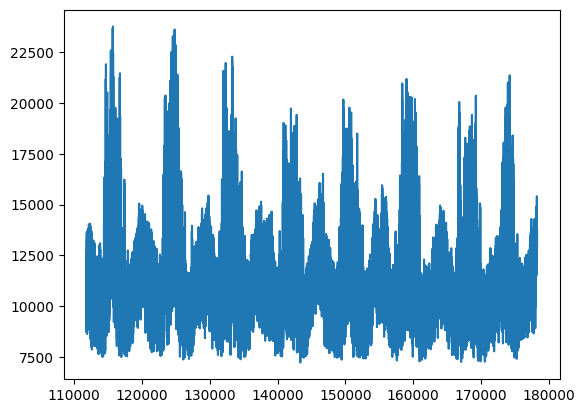

In [ ]:
#for name in ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJME', 'PJMW', 'PJM_Load']:
for name in ['COMED']:
  a = df[~df[name].isna()]
  print(name, a.Datetime.min(), a.Datetime.max())
  print(name, a.shape)
  a[name].plot()
  plt.show()

In [ ]:
comed_data = df[~df.COMED.isna()]
comed_data = comed_data[['Datetime','Date','COMED']]
comed_data["Date"] = pd.to_datetime(comed_data['Date'], format='%Y-%m-%d')
#comed_data = comed_data.sort_values(['Datetime'])
print(comed_data.shape)
comed_data = comed_data.drop_duplicates()
print(comed_data.shape)
comed_data.head()

(66497, 3)
(66497, 3)


Datetime       Date   COMED
111765 2011-12-31 01:00:00 2011-12-31  9970.0
111766 2011-12-31 02:00:00 2011-12-31  9428.0
111767 2011-12-31 03:00:00 2011-12-31  9059.0
111768 2011-12-31 04:00:00 2011-12-31  8817.0
111769 2011-12-31 05:00:00 2011-12-31  8743.0

In [ ]:
comed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66497 entries, 111765 to 178261
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  66497 non-null  datetime64[ns]
 1   Date      66497 non-null  datetime64[ns]
 2   COMED     66497 non-null  float64       
dtypes: datetime64[ns](2), float64(1)
memory usage: 2.0 MB


In [ ]:
check = comed_data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/comed_data.shape[0]*100
check


Count  perc
Datetime      0   0.0
Date          0   0.0
COMED         0   0.0

(745, 4)


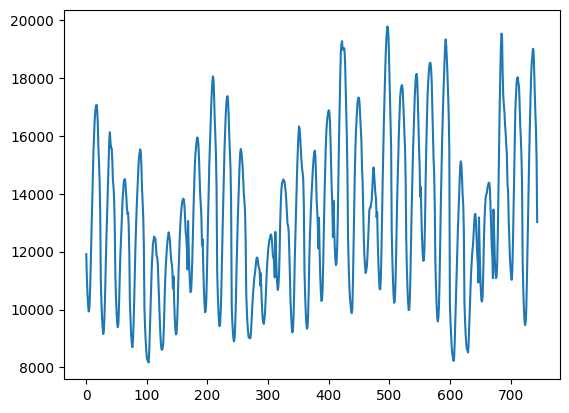

index            Datetime       Date    COMED
0    173127 2018-08-02 01:00:00 2018-08-02  11916.0
1    173128 2018-08-02 02:00:00 2018-08-02  11095.0
2    173129 2018-08-02 03:00:00 2018-08-02  10530.0
3    173130 2018-08-02 04:00:00 2018-08-02  10165.0
4    173131 2018-08-02 05:00:00 2018-08-02   9931.0
..      ...                 ...        ...      ...
740  173867 2018-07-03 21:00:00 2018-07-03  17483.0
741  173868 2018-07-03 22:00:00 2018-07-03  16798.0
742  173869 2018-07-03 23:00:00 2018-07-03  16263.0
743  173870 2018-07-04 00:00:00 2018-07-04  15221.0
744  173894 2018-07-03 00:00:00 2018-07-03  13017.0

[745 rows x 4 columns]

In [ ]:
a = comed_data[comed_data.Date >= '2018-07-03']
a  = a.reset_index()
print(a.shape)
a.COMED.plot()
plt.show()
a

In [ ]:
ts = comed_data[comed_data.Date >= '2018-07-03']
ts = ts.sort_values(['Datetime'])
print(ts.shape)
ts = ts.reset_index()
ts = ts.COMED

(745, 3)


<ipython-input-5-03611daa8da7>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


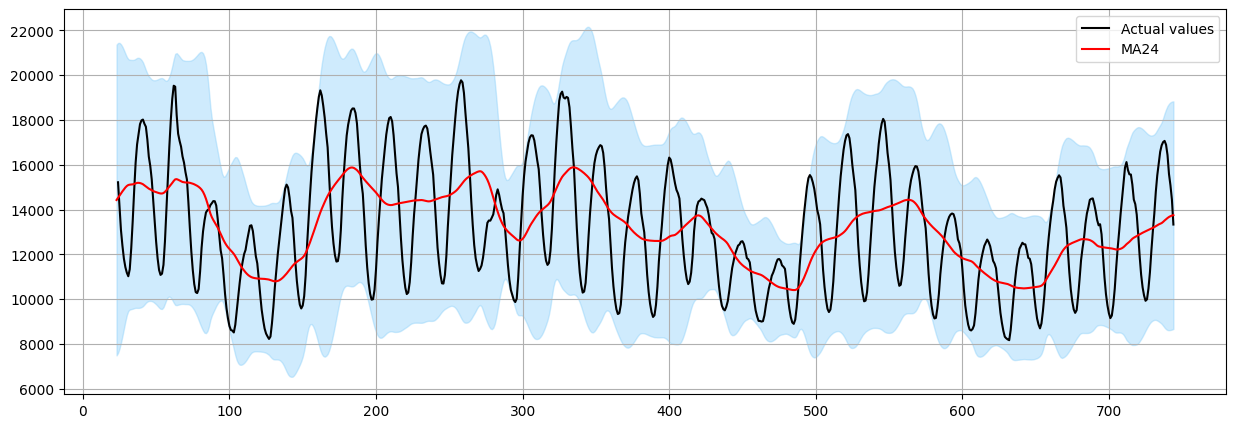

In [ ]:
plot_ts(ts, window=24)
plt.show()

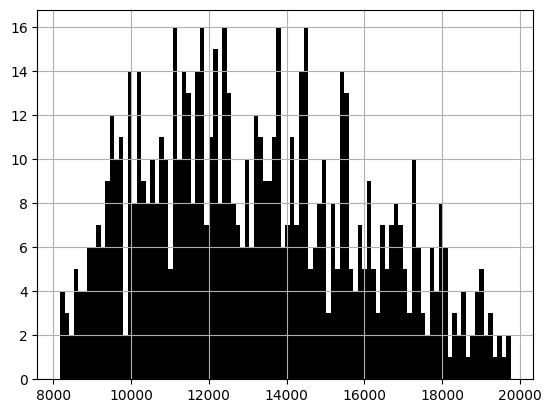

In [ ]:
## Plot histogram
ts.hist(color="black", bins=100)
plt.show()

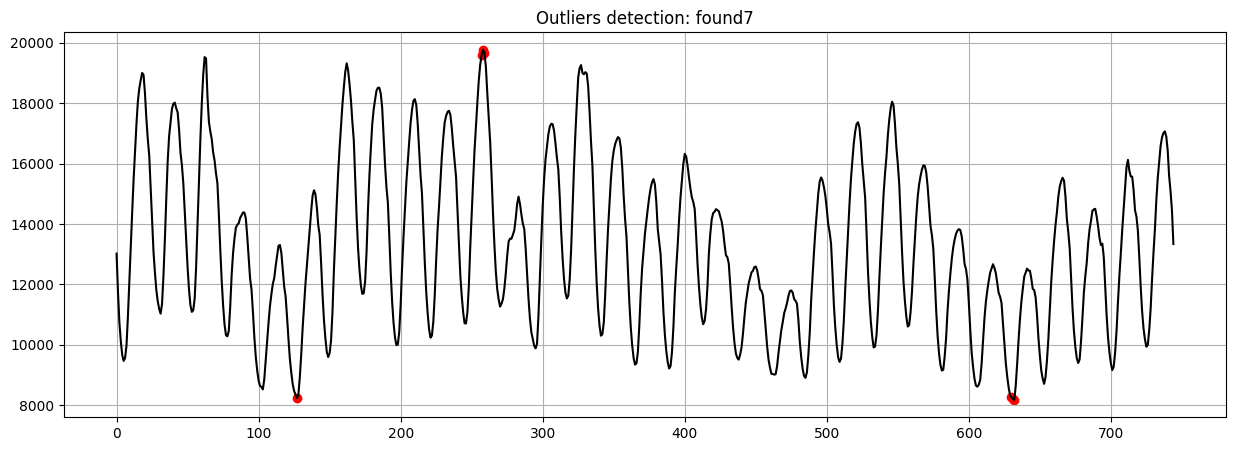

In [ ]:
dtf_outliers = find_outliers(ts, perc=0.01)

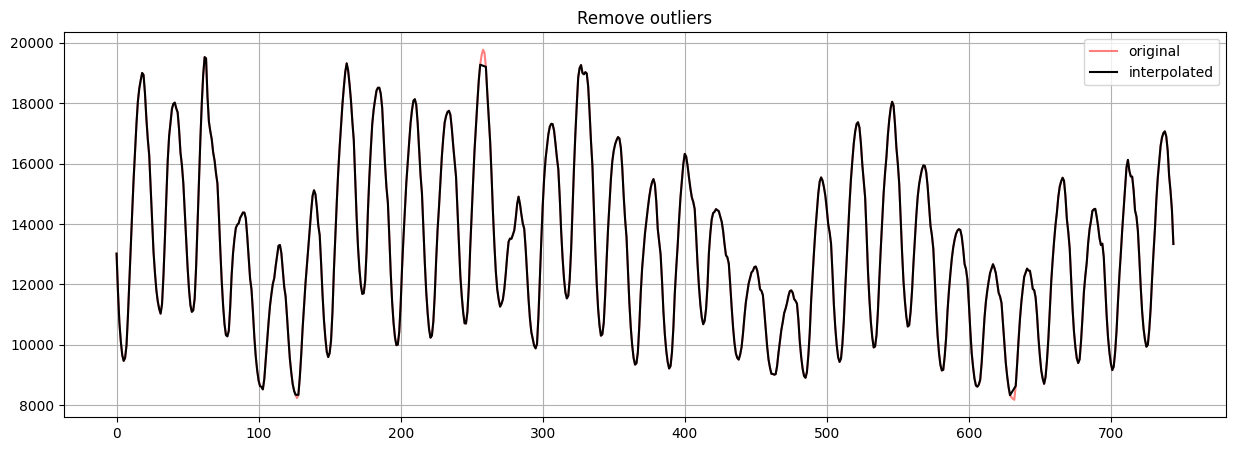

In [ ]:
### outliers index position ###
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index

### exclude outliers ###
ts_clean = remove_outliers(ts, outliers_idx=outliers_index_pos)

Decided against removing the outliers at this stage, though definitely a consideration going forward.

## Stationarity Test

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


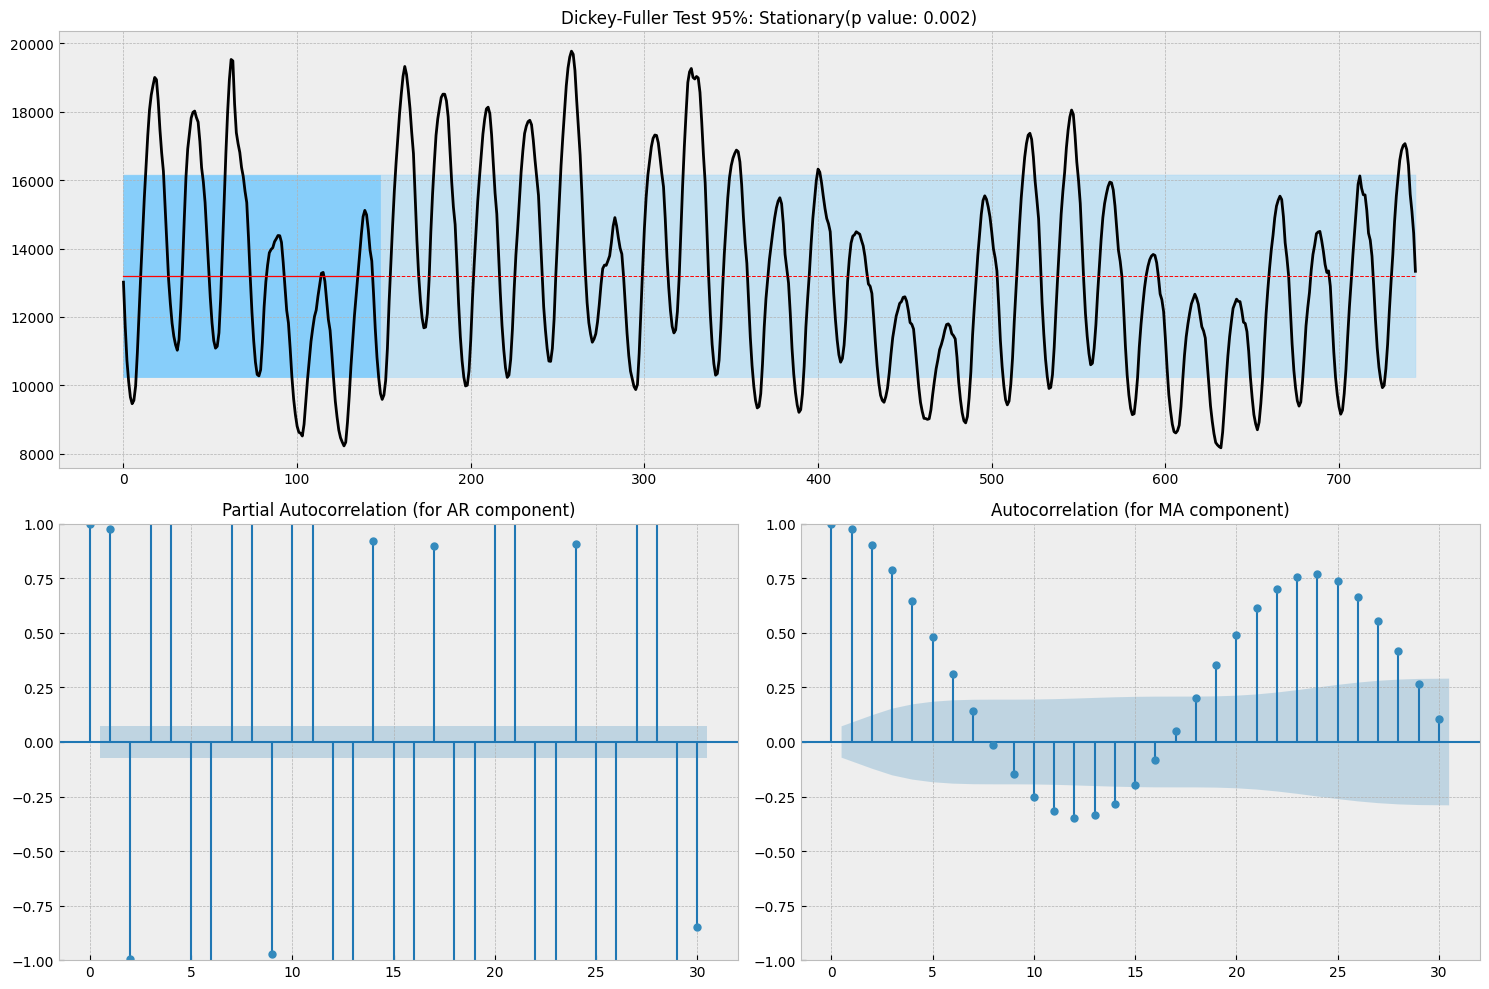

In [ ]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30)

In [ ]:
f_data = comed_data[comed_data.Date >= '2018-07-03'].copy()

f_data.rename(columns = {'COMED':'y', 'Datetime':'ds'}, inplace = True)
f_data = f_data.sort_values(['ds'])
f_data = f_data.reset_index(drop=True)

tdi = pd.DatetimeIndex(f_data.ds)
f_dataa = f_data.copy()
f_dataa.set_index(tdi, inplace=True)
f_dataa.drop(['ds','Date'], axis = 1, inplace=True)
print(f_dataa.shape)
f_dataa.head()
#f_data.tail()


(745, 1)


y
ds                          
2018-07-03 00:00:00  13017.0
2018-07-03 01:00:00  11743.0
2018-07-03 02:00:00  10726.0
2018-07-03 03:00:00  10103.0
2018-07-03 04:00:00   9653.0

In [ ]:
f = Forecaster(y = f_dataa['y'],
               current_dates = f_dataa.index,
               cis = True)
f

Forecaster(
    DateStartActuals=2018-07-03T00:00:00.000000000
    DateEndActuals=2018-08-03T00:00:00.000000000
    Freq=H
    N_actuals=745
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [ ]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

-2.342248251260446
0.15870375202065423


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


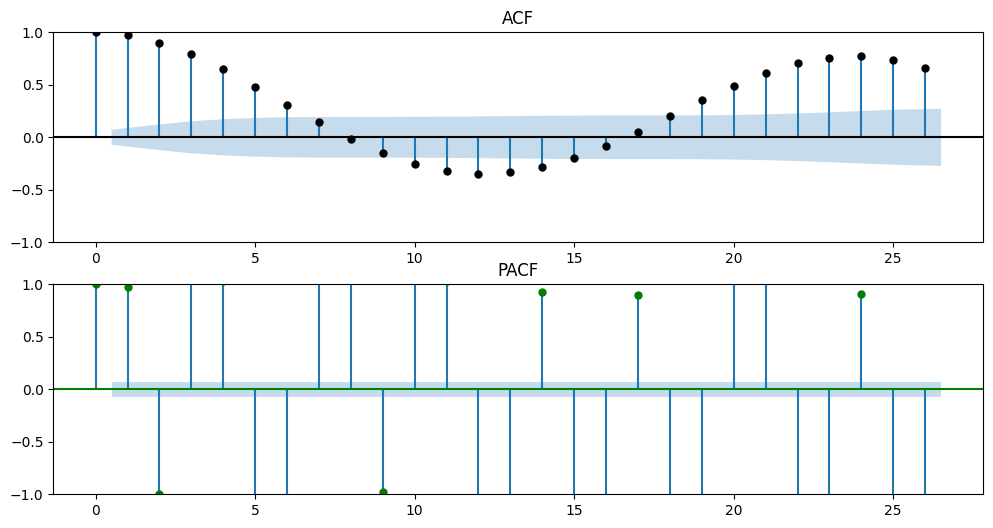

In [ ]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(lags=26,ax=axs[0],title='ACF',color='black')
f.plot_pacf(lags=26,ax=axs[1],title='PACF',color='green')
plt.show()

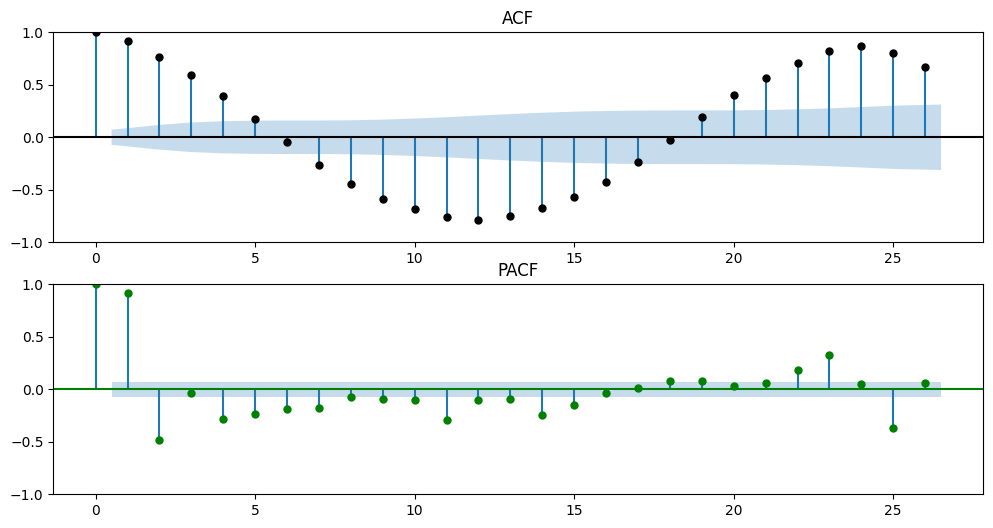

In [ ]:
figs, axs = plt.subplots(2, 1,figsize=(12,6))
f.plot_acf(diffy=True,ax=axs[0],title='ACF',lags=26,color='black')
f.plot_pacf(diffy=True,ax=axs[1],title='PACF',lags=26,color='green')
plt.show()

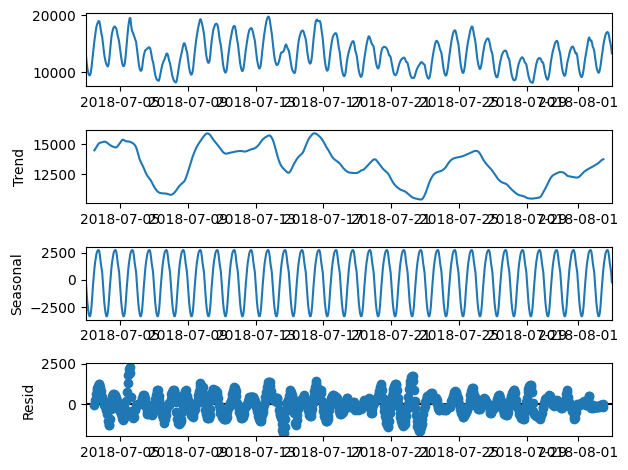

In [ ]:
f.seasonal_decompose().plot()
plt.show()

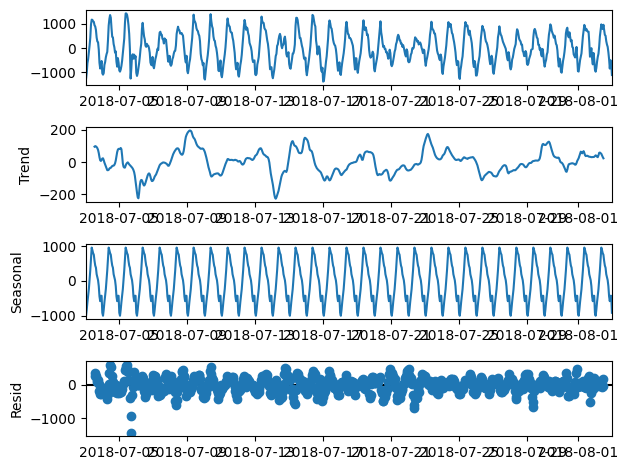

In [ ]:
f.seasonal_decompose(diffy=True).plot()
plt.show();

In [ ]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True,diffy=True)
print(stat)
print(pval)

-7.121785274873124
3.7063260446335977e-10


In [ ]:
X = f_dataa.y
diff = difference(X)
f_dataa['diff'] = [0] + diff
f_dataa.head()

y    diff
ds                                  
2018-07-03 00:00:00  13017.0     0.0
2018-07-03 01:00:00  11743.0 -1274.0
2018-07-03 02:00:00  10726.0 -1017.0
2018-07-03 03:00:00  10103.0  -623.0
2018-07-03 04:00:00   9653.0  -450.0

## Test-Train split

In [ ]:
f_data.head()

ds       Date        y
0 2018-07-03 00:00:00 2018-07-03  13017.0
1 2018-07-03 01:00:00 2018-07-03  11743.0
2 2018-07-03 02:00:00 2018-07-03  10726.0
3 2018-07-03 03:00:00 2018-07-03  10103.0
4 2018-07-03 04:00:00 2018-07-03   9653.0

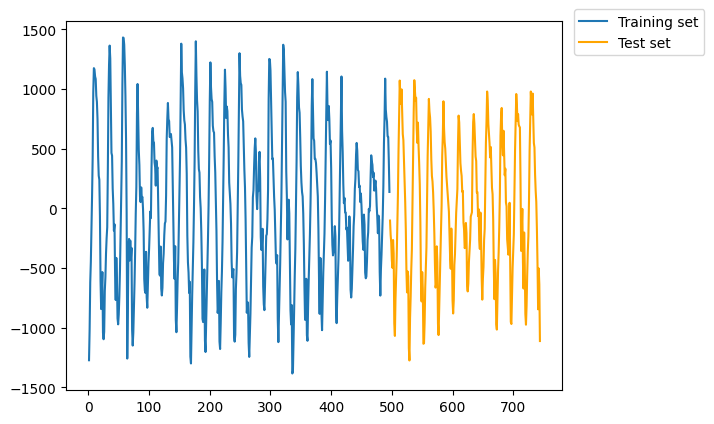

In [ ]:
X = f_data.y
f_data['diff'] = X.diff()
f_data = f_data.drop(['y'], axis = 1)
f_data.rename(columns = {'diff':'y'}, inplace = True)
f_data = f_data.drop(['Date'], axis = 1)
f_data = f_data.sort_values(['ds'])
f_data = f_data.reset_index(drop=True)

test_size = int(f_data.shape[0]/3)

df_train = f_data[:-test_size]
df_test = f_data[-test_size:]

plt.plot(df_train.y, label='Training set')
plt.plot(df_test.y, label='Test set', color='orange')
plt.legend(bbox_to_anchor=(1.3, 1.05));
plt.show()

In [ ]:
f_data.head()

ds       y
0 2018-07-03 00:00:00     NaN
1 2018-07-03 01:00:00 -1274.0
2 2018-07-03 02:00:00 -1017.0
3 2018-07-03 03:00:00  -623.0
4 2018-07-03 04:00:00  -450.0

## LSTM forecasting

In [ ]:
f.set_test_length(df_test.shape[0])         # 1. 12 observations to test the results
f.generate_future_dates(df_test.shape[0])   # 2. 12 future points to forecast
f.set_estimator('lstm')                     # 3. LSTM neural network

In [ ]:
f.add_seasonal_regressors(
    'month',
    'quarter',
    raw=False,
    sincos=True,
)

1/1 [==============================] - 0s 477ms/step


16/16 [==============================] - 0s 3ms/step


<Axes: xlabel='Date', ylabel='Values'>

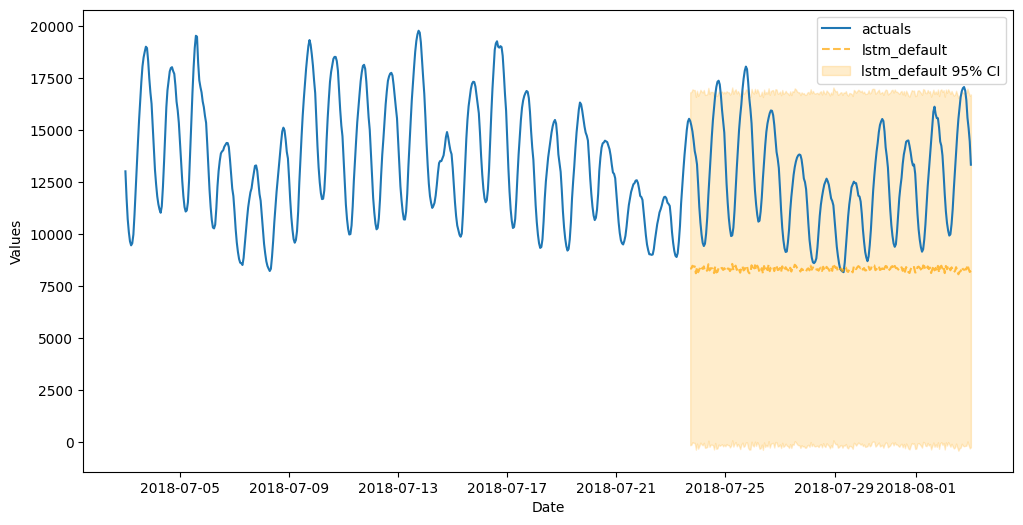

In [ ]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

The Smape loss value for lstm_default model is 0.380468
The RMSE loss value for lstm_default model is 4895.986169


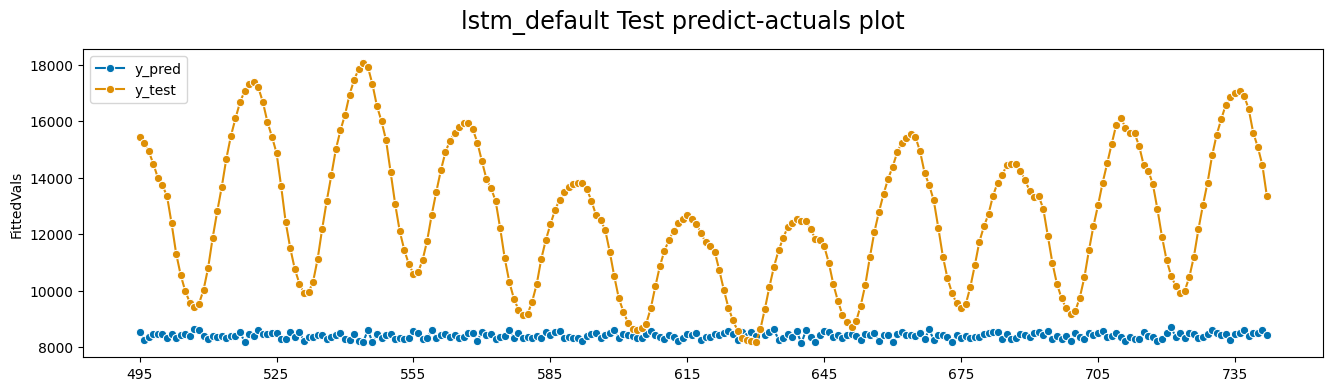

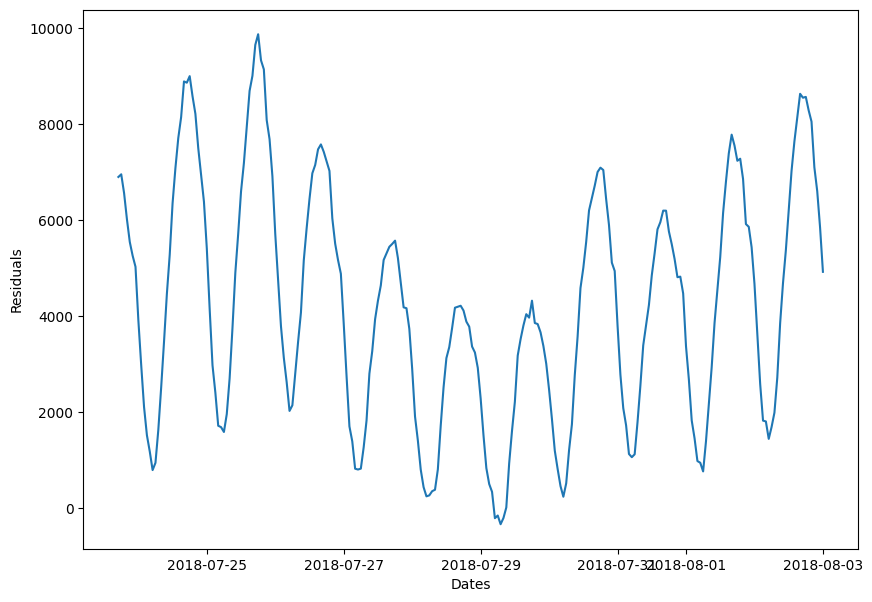

In [ ]:
a = f.export_fitted_vals('lstm_default')
forecst(a, 'lstm_default')

Epoch 1/5
6/6 [==============================] - 7s 216ms/step - loss: 0.4975 - val_loss: 0.4418
Epoch 2/5
6/6 [==============================] - 0s 40ms/step - loss: 0.4871 - val_loss: 0.4303
Epoch 3/5
6/6 [==============================] - 0s 33ms/step - loss: 0.4758 - val_loss: 0.4175
Epoch 4/5
6/6 [==============================] - 0s 39ms/step - loss: 0.4632 - val_loss: 0.4029
Epoch 5/5
1/1 [==============================] - 1s 1s/step
Epoch 1/5
12/12 [==============================] - 4s 68ms/step - loss: 0.4479 - val_loss: 0.3352
Epoch 2/5
12/12 [==============================] - 0s 18ms/step - loss: 0.4250 - val_loss: 0.3129
Epoch 3/5
12/12 [==============================] - 0s 17ms/step - loss: 0.3927 - val_loss: 0.2804
Epoch 4/5
12/12 [==============================] - 0s 17ms/step - loss: 0.3420 - val_loss: 0.2332
Epoch 5/5
15/15 [==============================] - 0s 3ms/step


<Axes: xlabel='Date', ylabel='Values'>

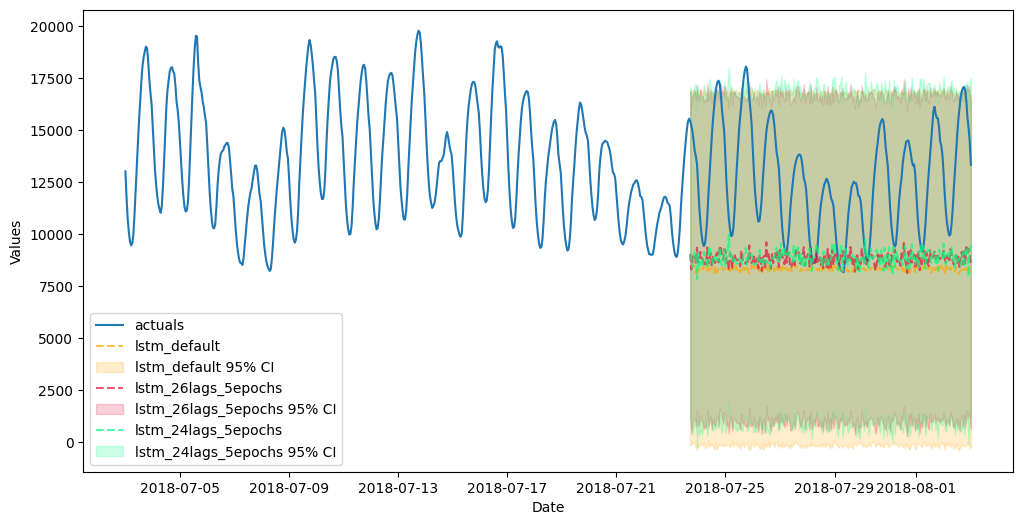

In [ ]:
f.manual_forecast(
    call_me='lstm_24lags_5epochs',
    lags=24,
    epochs=5,
    validation_split=.2,
    shuffle=True,
)
f.plot_test_set(ci=True)

The Smape loss value for lstm_24lags_5epochs model is 0.200369
The RMSE loss value for lstm_24lags_5epochs model is 3045.303889


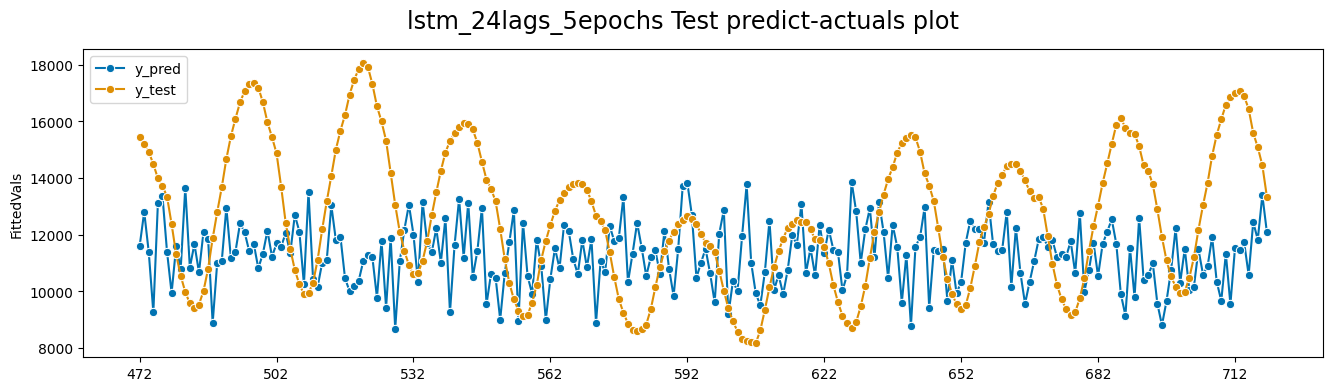

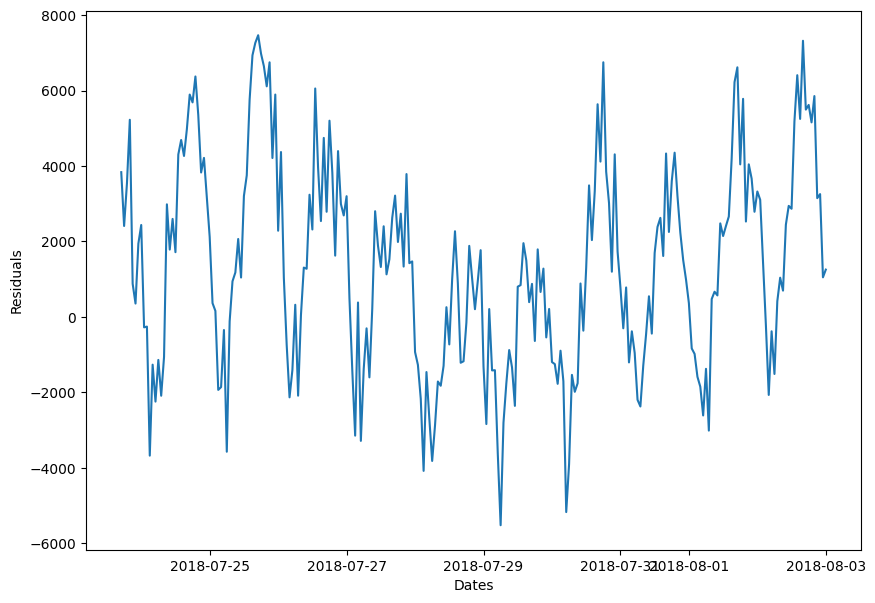

In [ ]:
a = f.export_fitted_vals('lstm_24lags_5epochs')
forecst(a, 'lstm_24lags_5epochs')

In [ ]:
f

Forecaster(
    DateStartActuals=2018-07-03T00:00:00.000000000
    DateEndActuals=2018-08-03T00:00:00.000000000
    Freq=H
    N_actuals=745
    ForecastLength=248
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26']
    TestLength=248
    ValidationMetric=rmse
    ForecastsEvaluated=['lstm_default', 'lstm_26lags_5epochs', 'lstm_24lags_5epochs']
    CILevel=0.95
    CurrentEstimator=lstm
    GridsFile=Grids
)

Epoch 1/25
6/6 [==============================] - 15s 308ms/step - loss: 0.4974 - val_loss: 0.4406
Epoch 2/25
6/6 [==============================] - 0s 47ms/step - loss: 0.4827 - val_loss: 0.4176
Epoch 3/25
6/6 [==============================] - 0s 53ms/step - loss: 0.4545 - val_loss: 0.3744
Epoch 4/25
6/6 [==============================] - 0s 47ms/step - loss: 0.4030 - val_loss: 0.3133
Epoch 5/25
6/6 [==============================] - 0s 43ms/step - loss: 0.3361 - val_loss: 0.2645
Epoch 6/25
6/6 [==============================] - 0s 45ms/step - loss: 0.2821 - val_loss: 0.2418
Epoch 7/25
6/6 [==============================] - 0s 47ms/step - loss: 0.2531 - val_loss: 0.2334
Epoch 8/25
6/6 [==============================] - 0s 51ms/step - loss: 0.2355 - val_loss: 0.2205
Epoch 9/25
6/6 [==============================] - 0s 47ms/step - loss: 0.2224 - val_loss: 0.2079
Epoch 10/25
6/6 [==============================] - 0s 46ms/step - loss: 0.2156 - val_loss: 0.2028
Epoch 11/25
6/6 [==========

<Axes: xlabel='Date', ylabel='Values'>

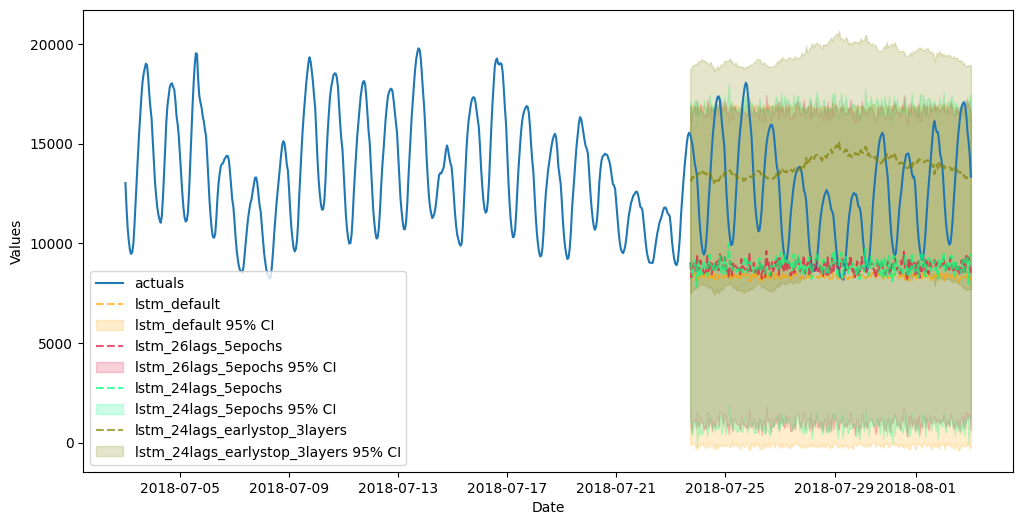

In [ ]:
f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0),
)

f.plot_test_set(ci=True)

The Smape loss value for lstm_24lags_earlystop_3layers model is 0.177297
The RMSE loss value for lstm_24lags_earlystop_3layers model is 2625.623897


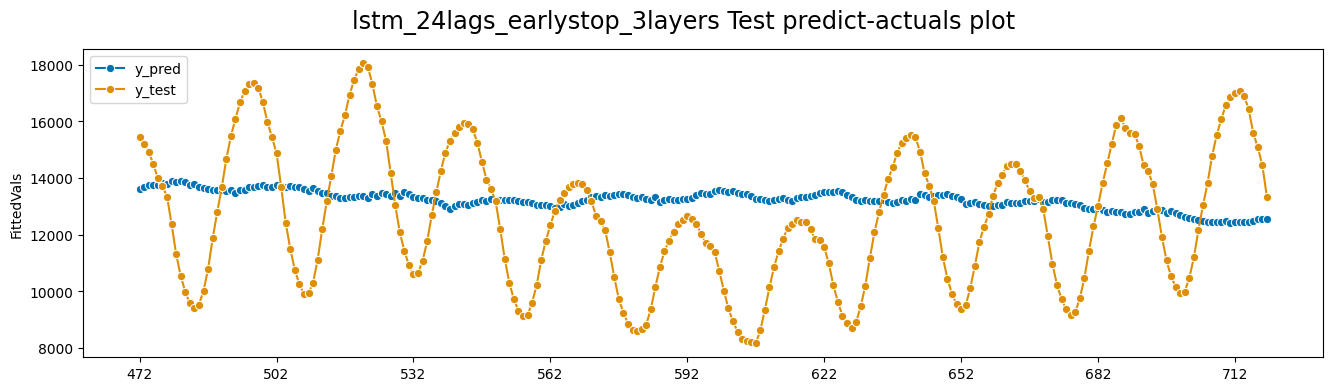

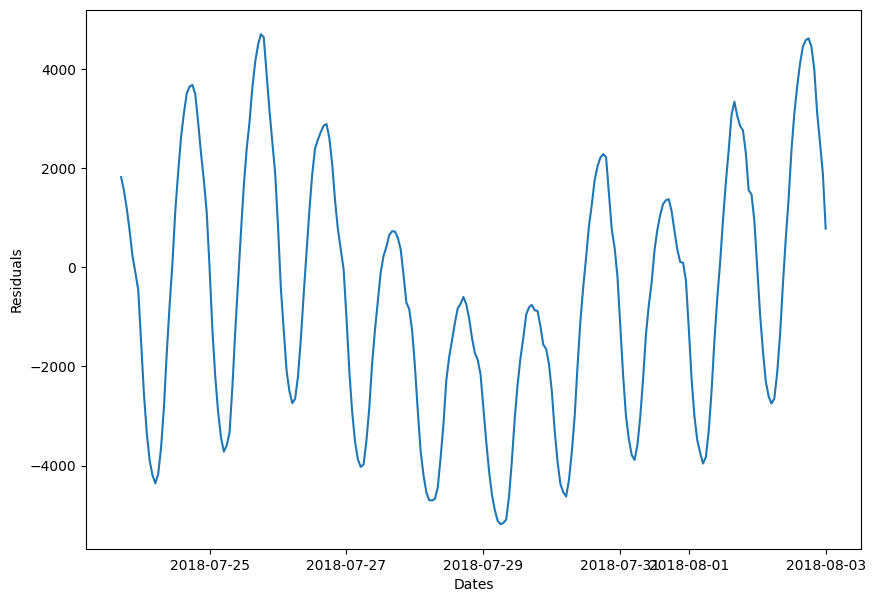

In [ ]:
a = f.export_fitted_vals('lstm_24lags_earlystop_3layers')
forecst(a, 'lstm_24lags_earlystop_3layers')

Epoch 1/15
6/6 [==============================] - 15s 433ms/step - loss: 0.4863 - val_loss: 0.3743
Epoch 2/15
6/6 [==============================] - 1s 88ms/step - loss: 0.3669 - val_loss: 0.2881
Epoch 3/15
6/6 [==============================] - 1s 95ms/step - loss: 0.2754 - val_loss: 0.2210
Epoch 4/15
6/6 [==============================] - 0s 86ms/step - loss: 0.2283 - val_loss: 0.2107
Epoch 5/15
6/6 [==============================] - 0s 84ms/step - loss: 0.2160 - val_loss: 0.2146
Epoch 6/15
6/6 [==============================] - 1s 126ms/step - loss: 0.2145 - val_loss: 0.2085
Epoch 7/15
6/6 [==============================] - 1s 134ms/step - loss: 0.2134 - val_loss: 0.2048
Epoch 8/15
6/6 [==============================] - 1s 135ms/step - loss: 0.2122 - val_loss: 0.2058
Epoch 9/15
6/6 [==============================] - 1s 148ms/step - loss: 0.2115 - val_loss: 0.2053
Epoch 10/15
6/6 [==============================] - 1s 143ms/step - loss: 0.2112 - val_loss: 0.2040
Epoch 11/15
6/6 [=====

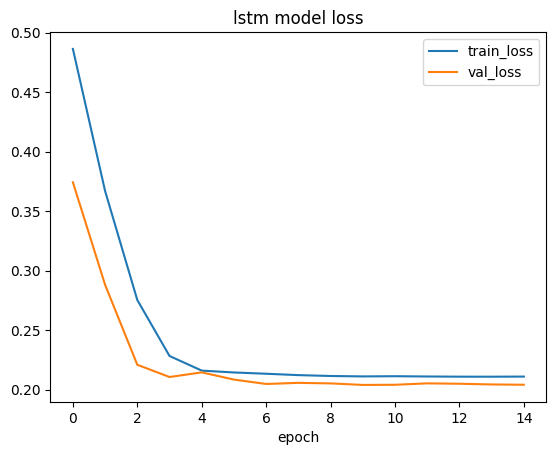

Epoch 1/15
12/12 [==============================] - 14s 238ms/step - loss: 0.3841 - val_loss: 0.2542
Epoch 2/15
12/12 [==============================] - 1s 79ms/step - loss: 0.2321 - val_loss: 0.1950
Epoch 3/15
12/12 [==============================] - 1s 88ms/step - loss: 0.2061 - val_loss: 0.1940
Epoch 4/15
12/12 [==============================] - 1s 91ms/step - loss: 0.2030 - val_loss: 0.1940
Epoch 5/15
12/12 [==============================] - 1s 85ms/step - loss: 0.2021 - val_loss: 0.1928
Epoch 6/15
12/12 [==============================] - 1s 82ms/step - loss: 0.2020 - val_loss: 0.1943
Epoch 7/15
12/12 [==============================] - 1s 80ms/step - loss: 0.2016 - val_loss: 0.1927
Epoch 8/15
12/12 [==============================] - 1s 90ms/step - loss: 0.2015 - val_loss: 0.1947
Epoch 9/15
12/12 [==============================] - 2s 139ms/step - loss: 0.2014 - val_loss: 0.1904
Epoch 10/15
12/12 [==============================] - 2s 139ms/step - loss: 0.2002 - val_loss: 0.1917
Epoch

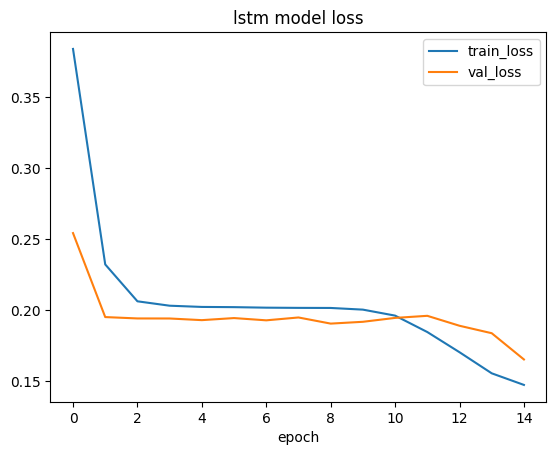

<Axes: xlabel='Date', ylabel='Values'>

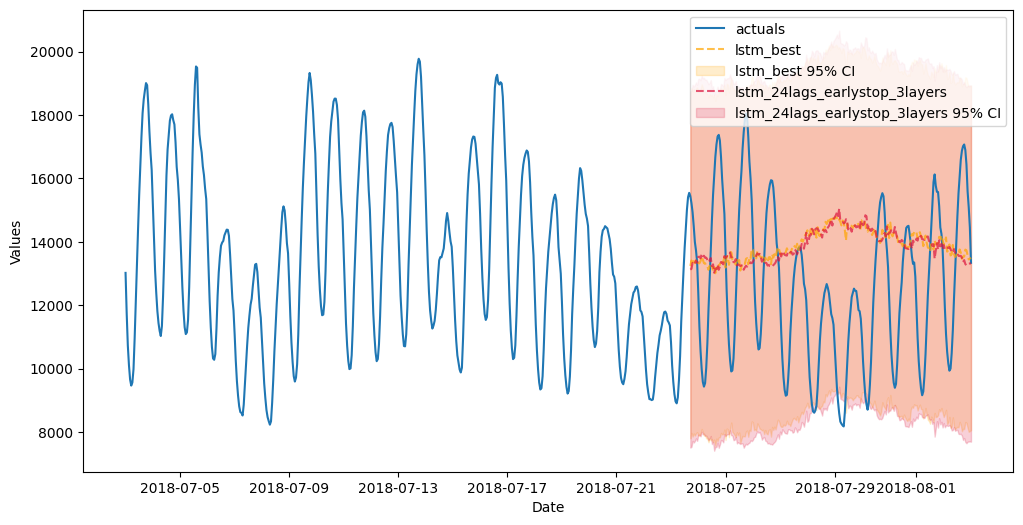

In [ ]:
f.manual_forecast(
    call_me='lstm_best',
    lags=24,
    batch_size=32,
    epochs=15,
    validation_split=.2,
    shuffle=True,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.001,
    lstm_layer_sizes=(72,)*4,
    dropout=(0,)*4,
    plot_loss=True
)
#f.plot_test_set(ci=True)
f.plot_test_set(order_by='TestSetRMSE',models='top_2',ci=True)

The Smape loss value for lstm_best model is 0.108084
The RMSE loss value for lstm_best model is 1749.411669


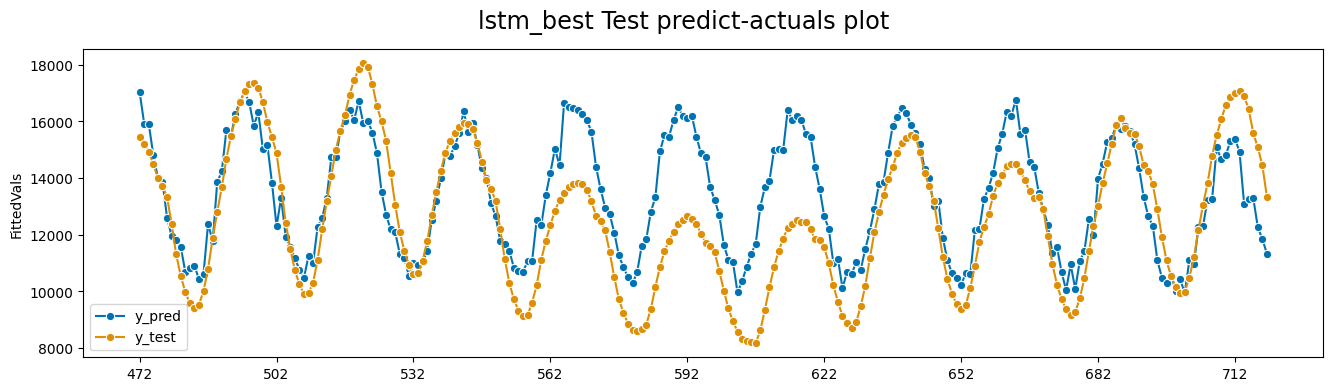

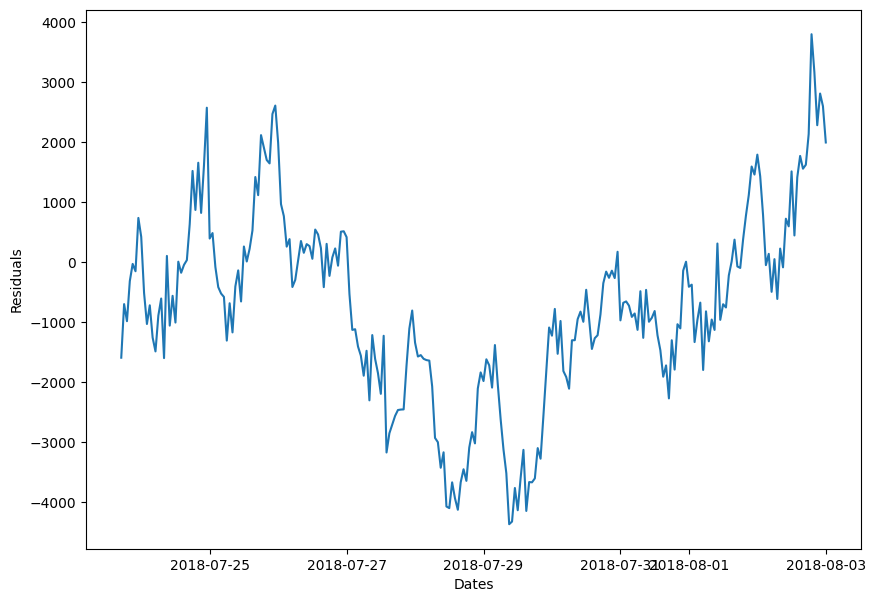

In [ ]:
a = f.export_fitted_vals('lstm_best')
forecst(a, 'lstm_best')

## ARIMA forecasting

In [ ]:
f = Forecaster(y = data['y'],
               current_dates = data['ds'],
               cis = True)

f.set_test_length(df_test.shape[0])
f.generate_future_dates(df_test.shape[0])
f.set_estimator('arima')

In [ ]:
auto_arima(
    f,
    m=24,
    trace=True,
    stepwise=True,
    call_me='arima_3',
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=11079.364, Time=14.99 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=11927.247, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=11284.417, Time=7.09 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=11228.596, Time=3.07 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=11925.251, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=11017.588, Time=14.61 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=11266.154, Time=2.00 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=11031.737, Time=43.53 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=11165.399, Time=12.34 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=inf, Time=47.90 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=inf, Time=6.39 sec
 ARIMA(2,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=6.11 sec
 ARIMA(3,0,2)(0,0,1)[24] intercept   : AIC=inf, Time=16.19 sec
 ARIMA(2,0,3)(0,0,1)[24] intercept   : AIC=inf, Time=17.61 sec
 ARIMA(1,0,1)(0,0,1)[24] int

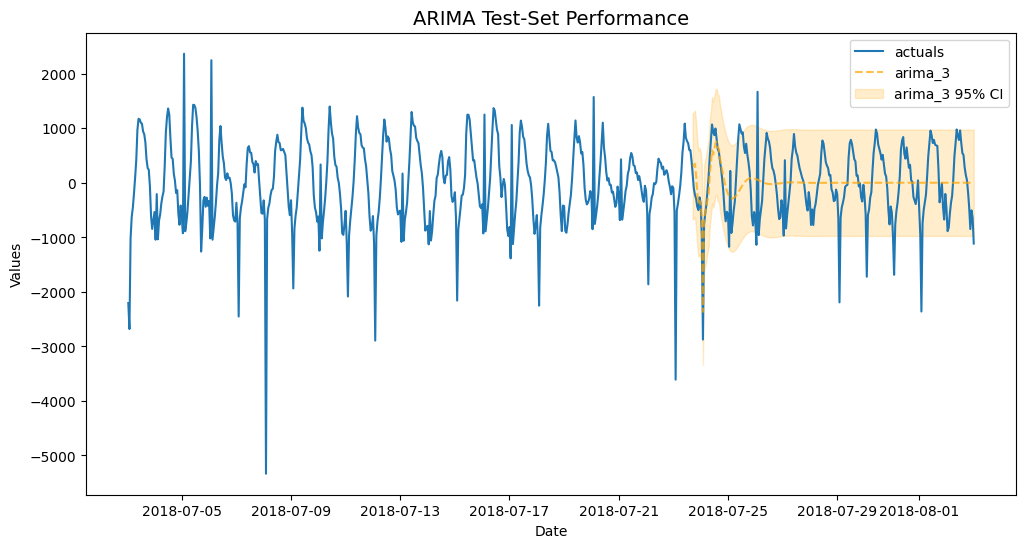

In [ ]:
f.plot_test_set(ci=True,models='arima_3')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

The Smape loss value for arima_3 model is 0.502057
The RMSE loss value for arima_3 model is 273.820252


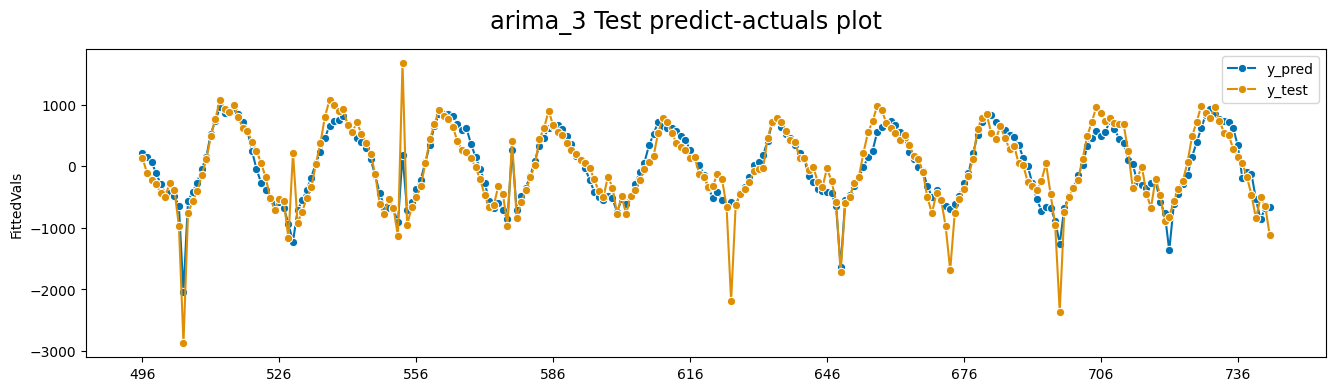

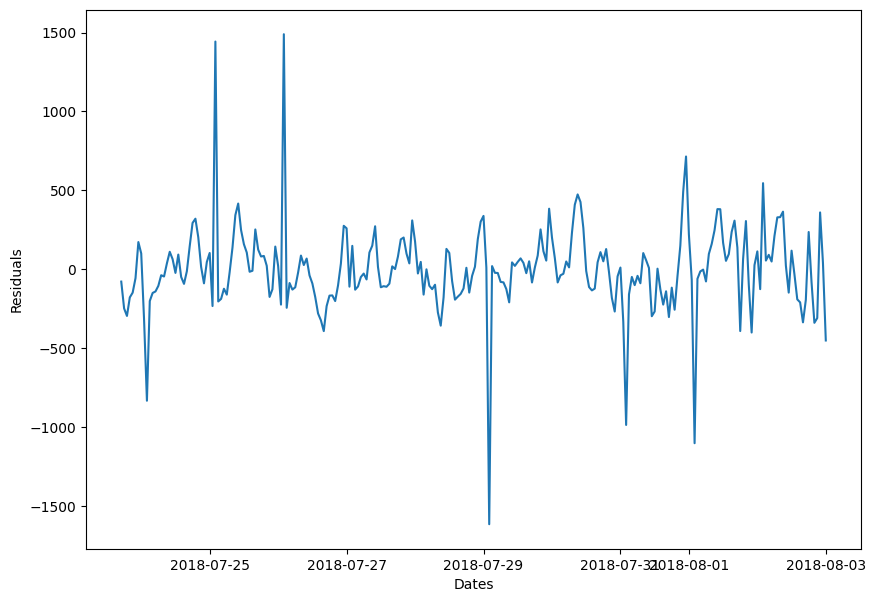

In [ ]:
a = f.export_fitted_vals('arima_3')
forecst(a, 'arima_3')

## Prophet models

In [ ]:
print(df_train.shape, df_test.shape)
#df_test.head()

(497, 2) (248, 2)


In [ ]:
check = df_test.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/df_test.shape[0]*100
#check

In [ ]:
df_train = df_train[~df_train.y.isna()]
df_test = df_test[~df_test.y.isna()]

add_datepart(df_train, 'ds', drop = False)
train_ph = train_dset(df_train,'ds')
train_ph.head()

df_test = df_test[~df_test.y.isna()]
add_datepart(df_test, 'ds', drop = False)
test_ph = train_dset(df_test,'ds')
test_ph = test_ph[list(train_ph.columns)]
#test_ph.head()

<ipython-input-10-eb3dfbe05590>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
<ipython-input-10-eb3dfbe05590>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
<ipython-input-10-eb3dfbe05590>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
<

In [ ]:
list(test_ph.columns)

['ds', 'y', 'Week', 'Day', 'Dayofweek', 'Dayofyear']

In [ ]:
holidays = pd.DataFrame({
  'holiday':'federal',
  'ds': pd.to_datetime(['2018-07-04']),
  'lower_window': -2,
  'upper_window': 2,
})


In [ ]:
# Define the time series model
model = Prophet(holidays=holidays)

# Fit the model
model.fit(train_ph)

# Predict using the fitted model
forecast = model.predict(test_ph)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa8tqtxx/aaogr_0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa8tqtxx/vyuyhfyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93068', 'data', 'file=/tmp/tmpwa8tqtxx/aaogr_0z.json', 'init=/tmp/tmpwa8tqtxx/vyuyhfyq.json', 'output', 'file=/tmp/tmpwa8tqtxx/prophet_modeldpumack2/prophet_model-20230726113812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
print(list(forecast.columns))

['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'daily', 'daily_lower', 'daily_upper', 'federal', 'federal_lower', 'federal_upper', 'holidays', 'holidays_lower', 'holidays_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat']


The Smape loss value for Prophet model is 0.502842
The RMSE loss value for Prophet model is 338.969092


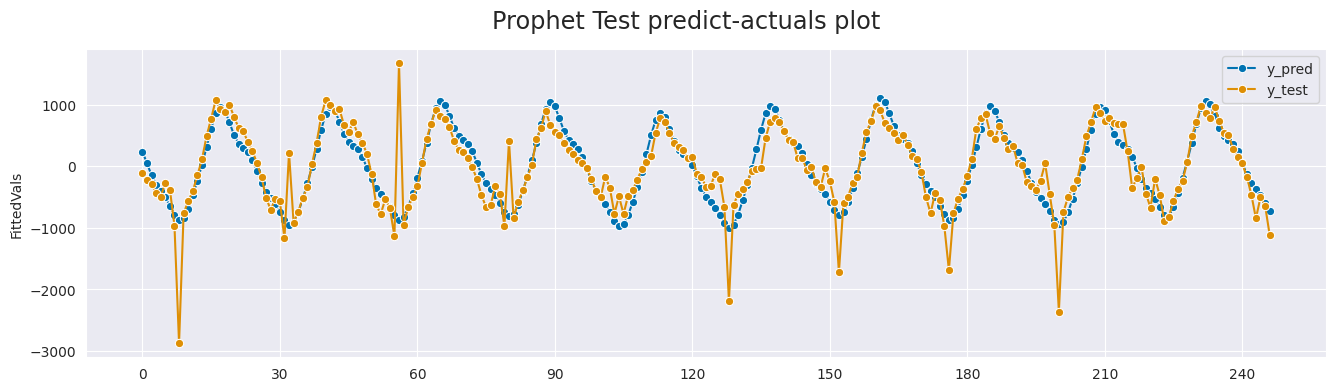

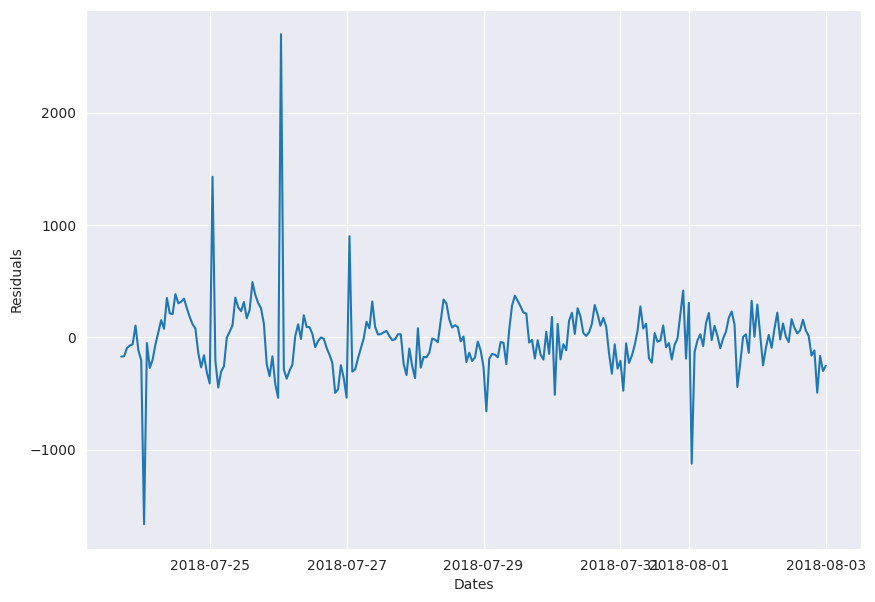

In [ ]:
forecast = pd.concat([forecast,test_ph['y']], axis = 1)
forecast.rename(columns = {'ds':'DATE', 'y':'Actuals', 'yhat':'FittedVals'}, inplace = True)
forecast['Residuals'] = forecast.Actuals - reg_data.FittedVals

forecst(forecast, 'Prophet')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa8tqtxx/tadusdi_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa8tqtxx/8np85axe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53930', 'data', 'file=/tmp/tmpwa8tqtxx/tadusdi_.json', 'init=/tmp/tmpwa8tqtxx/8np85axe.json', 'output', 'file=/tmp/tmpwa8tqtxx/prophet_modelxiobusqt/prophet_model-20230726110929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:09:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa8tqtxx/1vlx6_tv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwa8tqtxx/62jazgww.json
DEBUG:cmdstanp

497 247


INFO:prophet:Making 496 forecasts with cutoffs between 2018-07-03 00:59:59.999999925 and 2018-07-23 15:59:59.999999925


  0%|          | 0/496 [00:00<?, ?it/s]

Exception: ignored

<Figure size 1900x1500 with 0 Axes>

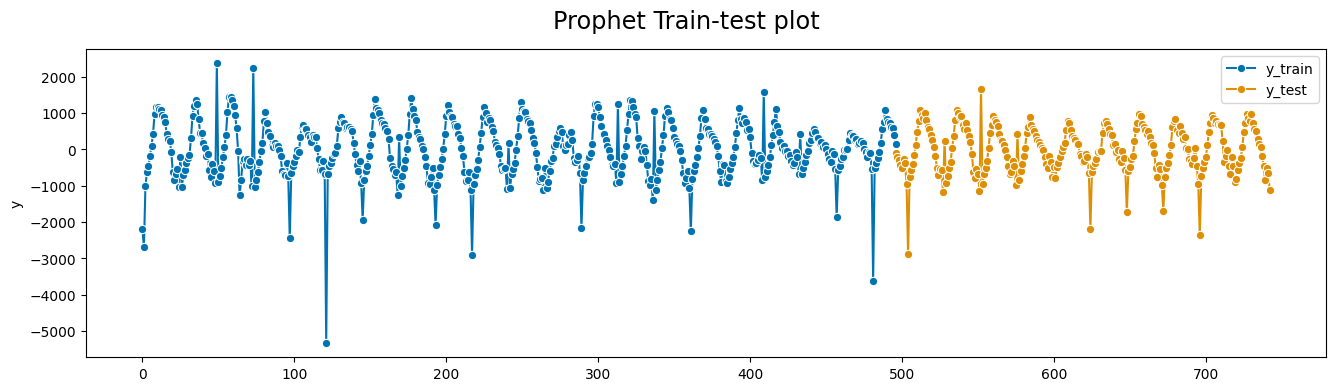

In [ ]:
cha_res = cap_floor(train_ph, test_ph, 'Prophet', initial = 600, period = 150,
                    horizon =  75, units = 'H')

In [ ]:
###############
### Results ###
###############

res_dset = pd.DataFrame()

res_dset = res_data(cha_res,'smape','Prophet',res_dset)

res_dset = res_data(cha_res,'rmse','Prophet',res_dset)

res_dset

In [ ]:
### Set up parameter grid ###

param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['multiplicative','additive'],
    'growth': ['linear','logistic'],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True],
    'daily_seasonality': [False]
}

### Generate all combinations of parameters ###

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

prop_params = hyper(df_train, df_test, '900 days', '300 days', '144 days')

In [ ]:
print('Prophet parameters ', prop_params)

In [ ]:
prophet_all = all_mod(df_train, df_test, prop_params, cha_res, '900 days', '300 days', '144 days', 'Prophet')

In [ ]:
perf_vals(prophet_all, meas = 'smape')

## Traditional models

In [ ]:
y_test = test_ph.y
test_ph['Hour'] = test_ph.ds.dt.hour
X_test = test_ph.drop(['y','cap','floor','ds'], axis = 1)

y_train = train_ph.y
train_ph['Hour'] = train_ph.ds.dt.hour
X_train = train_ph.drop(['y','cap','floor','ds'], axis = 1)

reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:766.59507	validation_1-rmse:634.99133
[100]	validation_0-rmse:450.18666	validation_1-rmse:362.52957
[200]	validation_0-rmse:326.23041	validation_1-rmse:327.17974
[213]	validation_0-rmse:314.43296	validation_1-rmse:329.20574


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

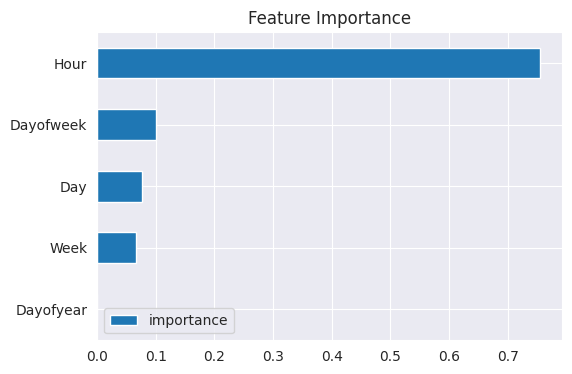

In [ ]:
fea_imp = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

fea_imp.sort_values('importance').plot(kind='barh',
                                       figsize=(6,4),
                                       title="Feature Importance")
plt.show()

The Smape loss value for XGB Regressor model is 0.575226
The RMSE loss value for XGB Regressor model is 318.558673


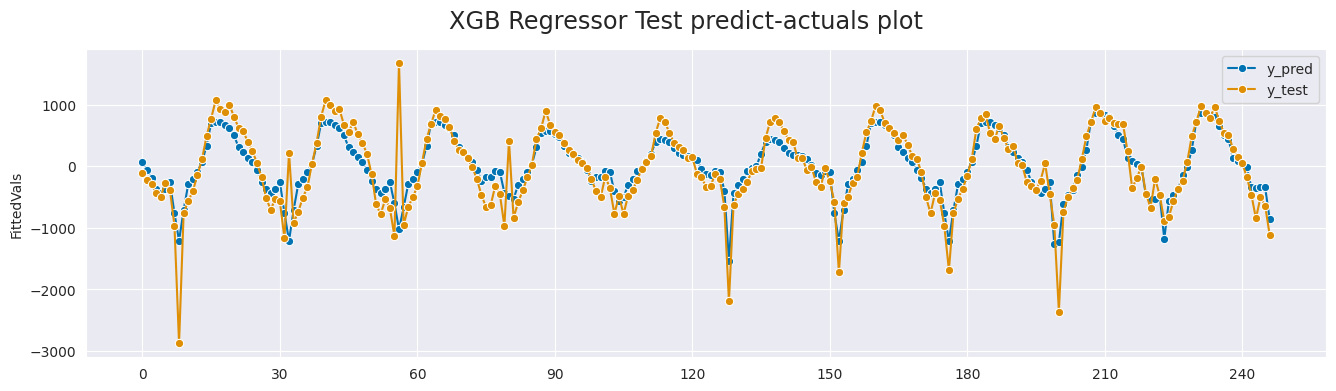

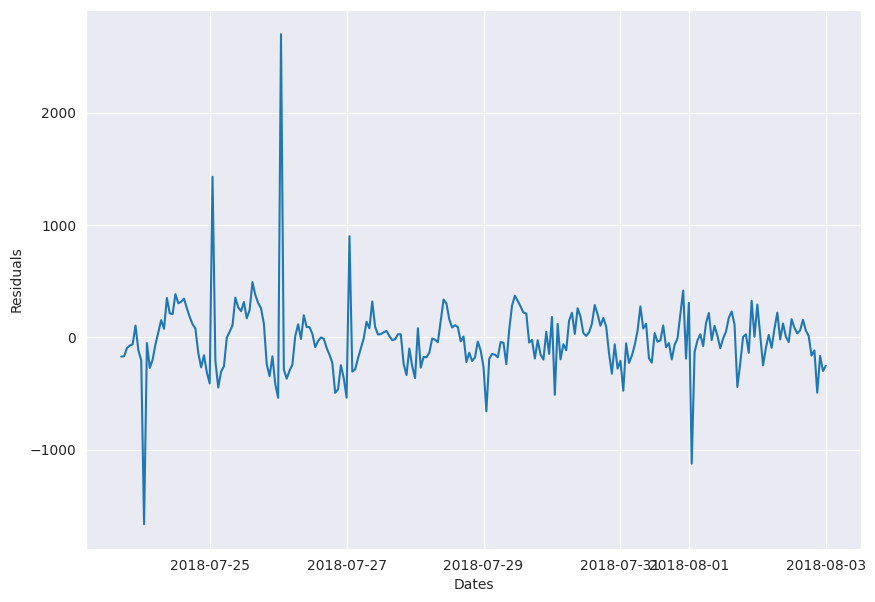

In [ ]:
yhat = reg.predict(X_test)
reg_data = test_ph.copy()
reg_data['yhat_xgb'] = yhat
reg_data.rename(columns = {'ds':'DATE', 'y':'Actuals', 'yhat_xgb':'FittedVals'}, inplace = True)
reg_data['Residuals'] = reg_data.Actuals - reg_data.FittedVals

forecst(reg_data, 'XGB Regressor')

In [ ]:
from sklearn.model_selection import GridSearchCV

# learning_rate hyperparameter was removed, to be used in tuning.
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3)

learning_rate_list = [0.01, 0.02, 0.03, 0.05, 0.1, 0.01]
max_depth_list = [1, 3, 4, 5, 6, 7]
n_estimators_list = [100, 300, 500, 1000, 2000, 3000]

param_grid = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list}

grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 10, error_score='raise')

grid_search.fit(X=X_train, y=np.ravel(y_train), eval_set=[(X_train, y_train), (X_test, y_test)])

Streaming output truncated to the last 5000 lines.
[120]	validation_0-rmse:453.25963	validation_1-rmse:309.89278
[121]	validation_0-rmse:452.74087	validation_1-rmse:309.89639
[122]	validation_0-rmse:452.01751	validation_1-rmse:309.71917
[123]	validation_0-rmse:451.32224	validation_1-rmse:309.54452
[124]	validation_0-rmse:450.64761	validation_1-rmse:309.39488
[125]	validation_0-rmse:449.99935	validation_1-rmse:309.24653
[126]	validation_0-rmse:449.37024	validation_1-rmse:309.12205
[127]	validation_0-rmse:448.76589	validation_1-rmse:308.99771
[128]	validation_0-rmse:448.17929	validation_1-rmse:308.89622
[129]	validation_0-rmse:447.61594	validation_1-rmse:308.79375
[130]	validation_0-rmse:447.06782	validation_1-rmse:308.70215
[131]	validation_0-rmse:446.66856	validation_1-rmse:308.72096
[132]	validation_0-rmse:446.14961	validation_1-rmse:308.65307
[133]	validation_0-rmse:445.77352	validation_1-rmse:308.68140
[134]	validation_0-rmse:445.39843	validation_1-rmse:308.64058
[135]	validation_0-

In [ ]:
grid_search.best_params_

In [ ]:
reg_hp = xgb.XGBRegressor(base_score=0.5,
                          booster='gbtree',
                          n_estimators = ,
                          objective='reg:linear',
                          max_depth = ,
                          learning_rate = )

reg_hp.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)


[11:50:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:759.70637	validation_1-rmse:627.27783
[100]	validation_0-rmse:439.33380	validation_1-rmse:306.49802
[200]	validation_0-rmse:402.57916	validation_1-rmse:317.57492
[300]	validation_0-rmse:367.66553	validation_1-rmse:344.98213
[400]	validation_0-rmse:347.10994	validation_1-rmse:356.75336
[499]	validation_0-rmse:324.90174	validation_1-rmse:361.50979


{'learning_rate': 0.03}

The Smape loss value for XGB Regressor model is 0.493318
The RMSE loss value for XGB Regressor model is 361.509785


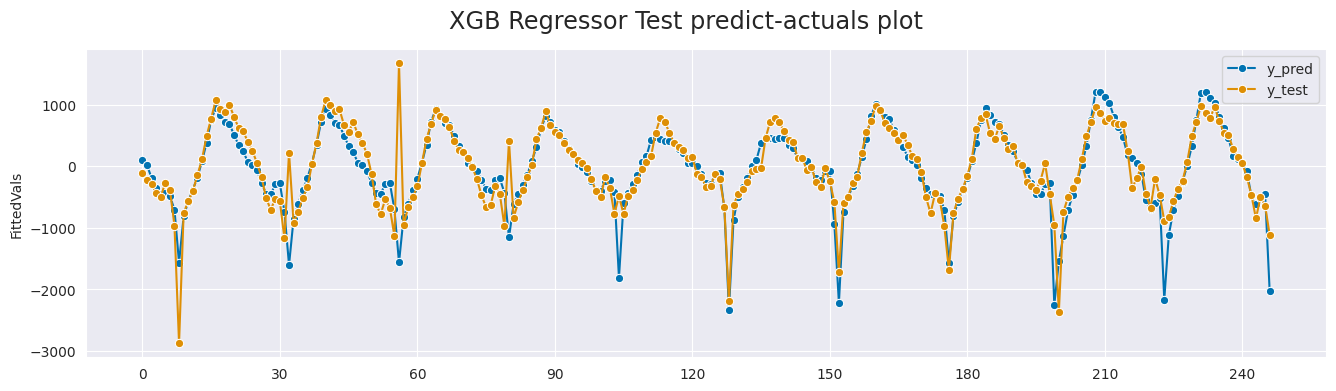

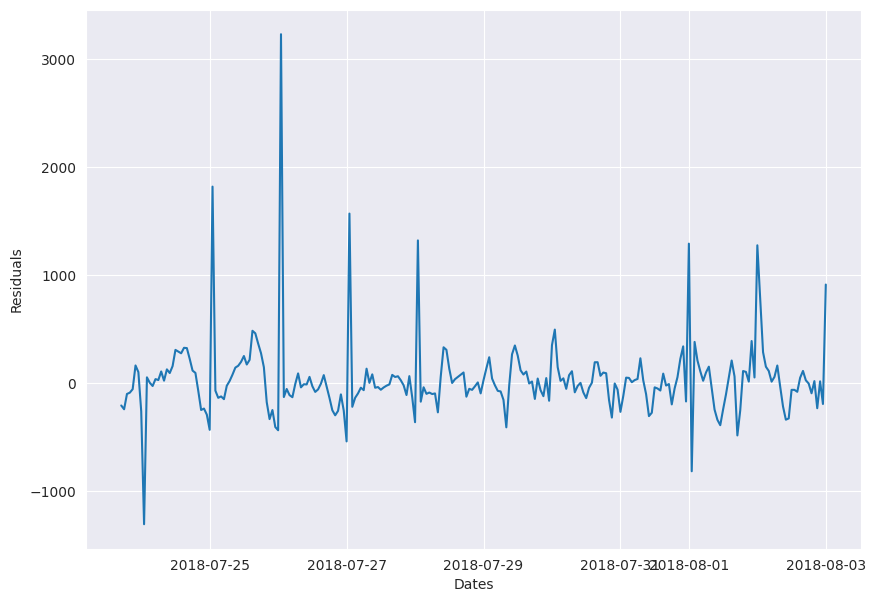

In [ ]:
yhat = reg_hp.predict(X_test)
reg_data_hp = test_ph.copy()
reg_data_hp['yhat_xgb'] = yhat
reg_data_hp.rename(columns = {'ds':'DATE', 'y':'Actuals', 'yhat_xgb':'FittedVals'}, inplace = True)
reg_data_hp['Residuals'] = reg_data_hp.Actuals - reg_data_hp.FittedVals

forecst(reg_data_hp, 'XGB Regressor')

## LSTM model

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

In [ ]:
data = data[~data.y.isna()]
dataset = data.y.values.astype('float32')
#Reshape the numpy array into a 2D array with 1 column

dataset = np.reshape(dataset, (-1, 1))
#Create an instance of the MinMaxScaler class to scale the values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
#Fit the MinMaxScaler to the transformed data and transform the values

dataset = scaler.fit_transform(dataset)
#Split the transformed data into a training set (80%) and a test set (20%)

train, test = dataset[:-test_size], dataset[-test_size:]

In [ ]:
print(train.shape, test.shape)

(496, 1) (248, 1)


In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
print(X_train.shape, X_test.shape)

(465, 30) (217, 30)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Defining the LSTM model
model = Sequential()

# Adding the first layer with 100 LSTM units and input shape of the data
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a dropout layer to avoid overfitting
model.add(Dropout(0.2))

# Adding a dense layer with 1 unit to make predictions
model.add(Dense(1))

# Compiling the model with mean squared error as the loss function and using Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the model on training data and using early stopping to avoid overfitting
history = model.fit(X_train, Y_train,
                    epochs=20,
                    batch_size=1240,
                    validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)],
                    verbose=1,
                    shuffle=False)

# Displaying a summary of the model
model.summary()

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.3115 - val_loss: 0.2184
Epoch 2/20
1/1 [==============================] - 0s 68ms/step - loss: 0.2259 - val_loss: 0.1459
Epoch 3/20
1/1 [==============================] - 0s 58ms/step - loss: 0.1512 - val_loss: 0.0886
Epoch 4/20
1/1 [==============================] - 0s 69ms/step - loss: 0.0949 - val_loss: 0.0468
Epoch 5/20
1/1 [==============================] - 0s 56ms/step - loss: 0.0544 - val_loss: 0.0201
Epoch 6/20
1/1 [==============================] - 0s 57ms/step - loss: 0.0264 - val_loss: 0.0077
Epoch 7/20
1/1 [==============================] - 0s 70ms/step - loss: 0.0141 - val_loss: 0.0074
Epoch 8/20
1/1 [==============================] - 0s 52ms/step - loss: 0.0163 - val_loss: 0.0154
Epoch 9/20
1/1 [==============================] - 0s 51ms/step - loss: 0.0236 - val_loss: 0.0271
Epoch 10/20
1/1 [==============================] - 0s 51ms/step - loss: 0.0362 - val_loss: 0.0377
Epoch 11/20
1/1 [==============

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


7/7 [==============================] - 0s 4ms/step


In [ ]:
len(Y_test[0][:217])

217

(217, 3)
The Smape loss value for COMED model is 1.540872
The RMSE loss value for COMED model is 1619.699166


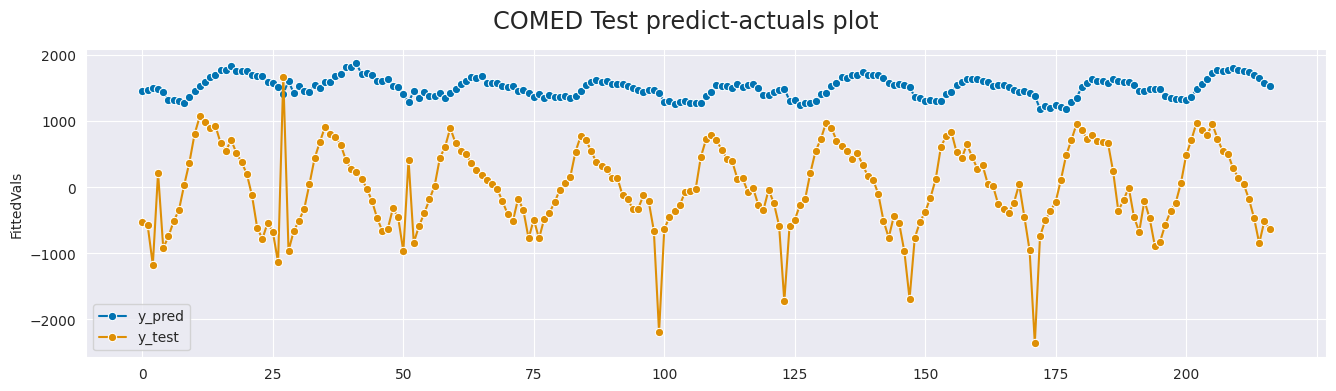

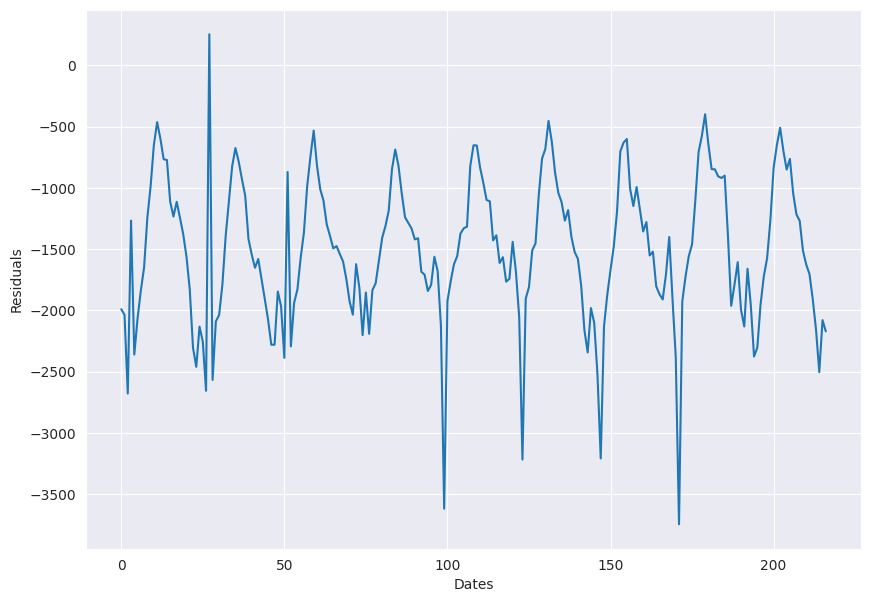

In [ ]:
lstm_data = pd.DataFrame(Y_test[0][:217],columns = ['y'])
lstm_data['yhat'] = test_predict[:,0][:217]
lstm_data['ds'] = lstm_data.index
print(lstm_data.shape)
lstm_data.head()
lstm_data.rename(columns = {'ds':'DATE', 'y':'Actuals', 'yhat':'FittedVals'}, inplace = True)
lstm_data['Residuals'] = lstm_data.Actuals - lstm_data.FittedVals
a = lstm_data.copy()

mape_ph = mean_absolute_percentage_error(a['Actuals'], a['FittedVals'], symmetric=True)
mse_ph = mean_squared_error(a['Actuals'], a['FittedVals'], squared=False)
print(f"The Smape loss value for {name} model is {mape_ph:.6f}")
print(f"The RMSE loss value for {name} model is {mse_ph:.6f}")

plot_series(a['FittedVals'], a['Actuals'], labels=["y_pred","y_test"], title = f'{name} Test predict-actuals plot')
plt.show();

f = plt.figure(figsize=(10, 7))
ax = sns.lineplot(x="DATE", y="Residuals", markers=True, data=a)
ax.set(xlabel='Dates', ylabel='Residuals')
plt.show();

In [ ]:
print(test_ph.shape)

(247, 9)
